In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt
import arch
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np

from financial_utils import plot_individual_stock, get_predicted_prices

In [2]:
plt.rcParams['figure.facecolor'] = 'white'

dashed_line_color = '#6E8AFF'
simulations_color = '#D5E0FF'
gt_color = 'black'
mean_color = '#FF2D43'
quartile_color = '#FFC7B2'

%matplotlib inline

In [3]:
# methods for the plots 

def legend_unique_labels():
    handles, labels = plt.gca().get_legend_handles_labels()

    unique_handles = []
    unique_labels = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)

    plt.legend(unique_handles, unique_labels)

def year_ticks():
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


def get_quartiles(prices):
    quartile_5 = np.percentile(prices, 5, axis=1)
    quartile_95 = np.percentile(prices, 95, axis=1)
    return quartile_5, quartile_95

In [4]:
company_list = ["AAPL", "GOOGL", "MSFT", "AMZN"]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

close_prices_df = pd.DataFrame()

for ticker, name in zip(company_list, company_name):
    file_path = os.path.join("../data", "financial", f"{ticker}.csv")
    
    df = pd.read_csv(file_path, parse_dates=["date"])
    df = df.set_index("date")
    df.rename(columns={"close": name}, inplace=True)
    df.drop(columns=["ticker", "open", "high", "low"], inplace=True)
    
    if close_prices_df.empty: close_prices_df = df
    else:
        close_prices_df = close_prices_df.merge(df, how="outer", left_index=True, right_index=True)

close_prices_df.sort_index(inplace=True)
close_prices_df.dropna(inplace=True)

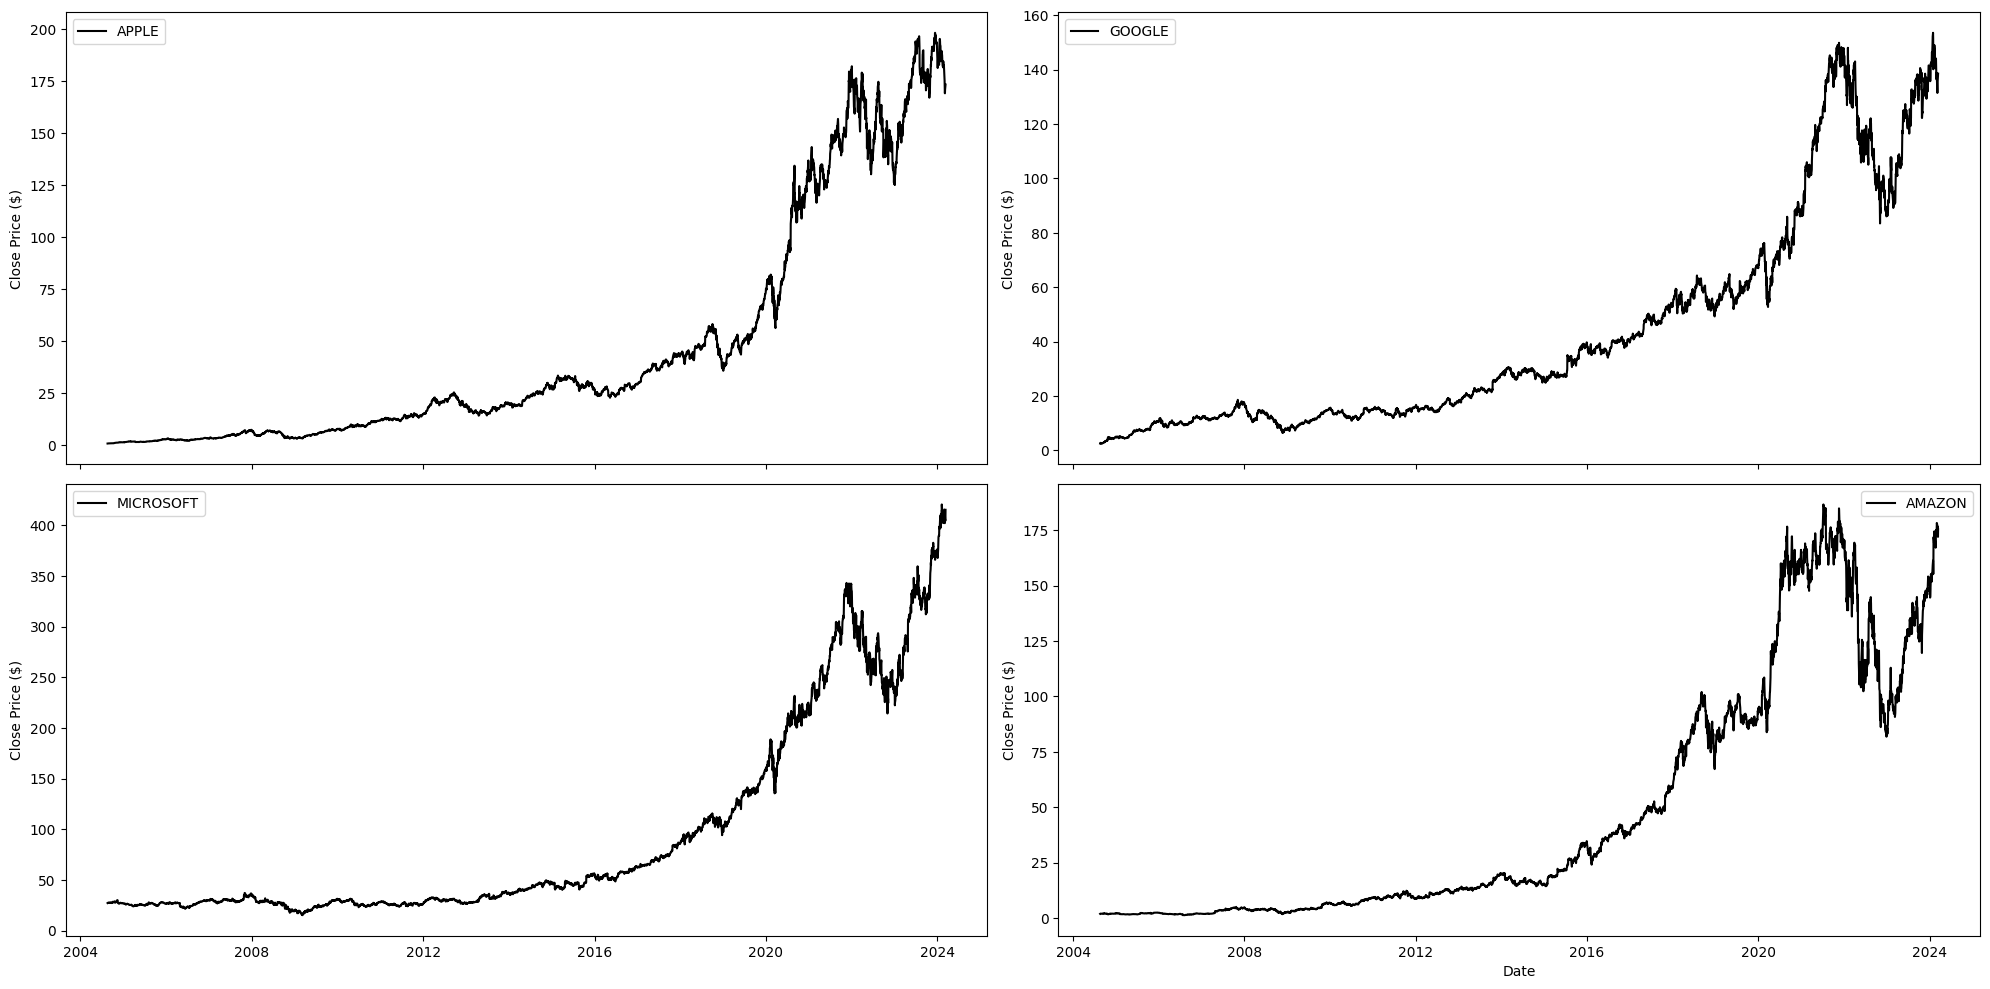

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color=gt_color)
    axs[row, col].set_ylabel('Close Price ($)')
    axs[row, col].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

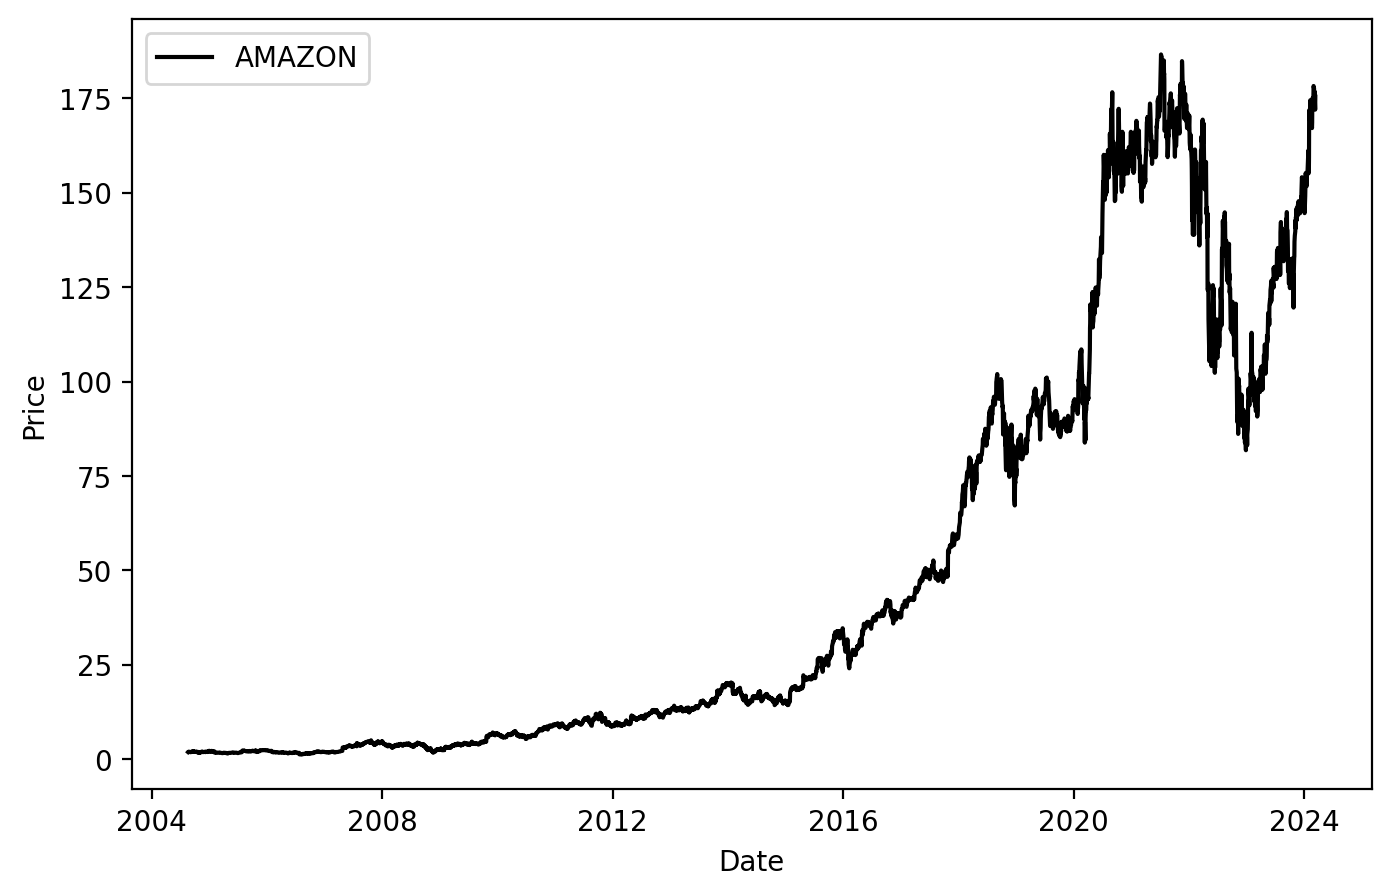

In [6]:
plot_individual_stock(df=close_prices_df, name='AMAZON', year_ticks=False)

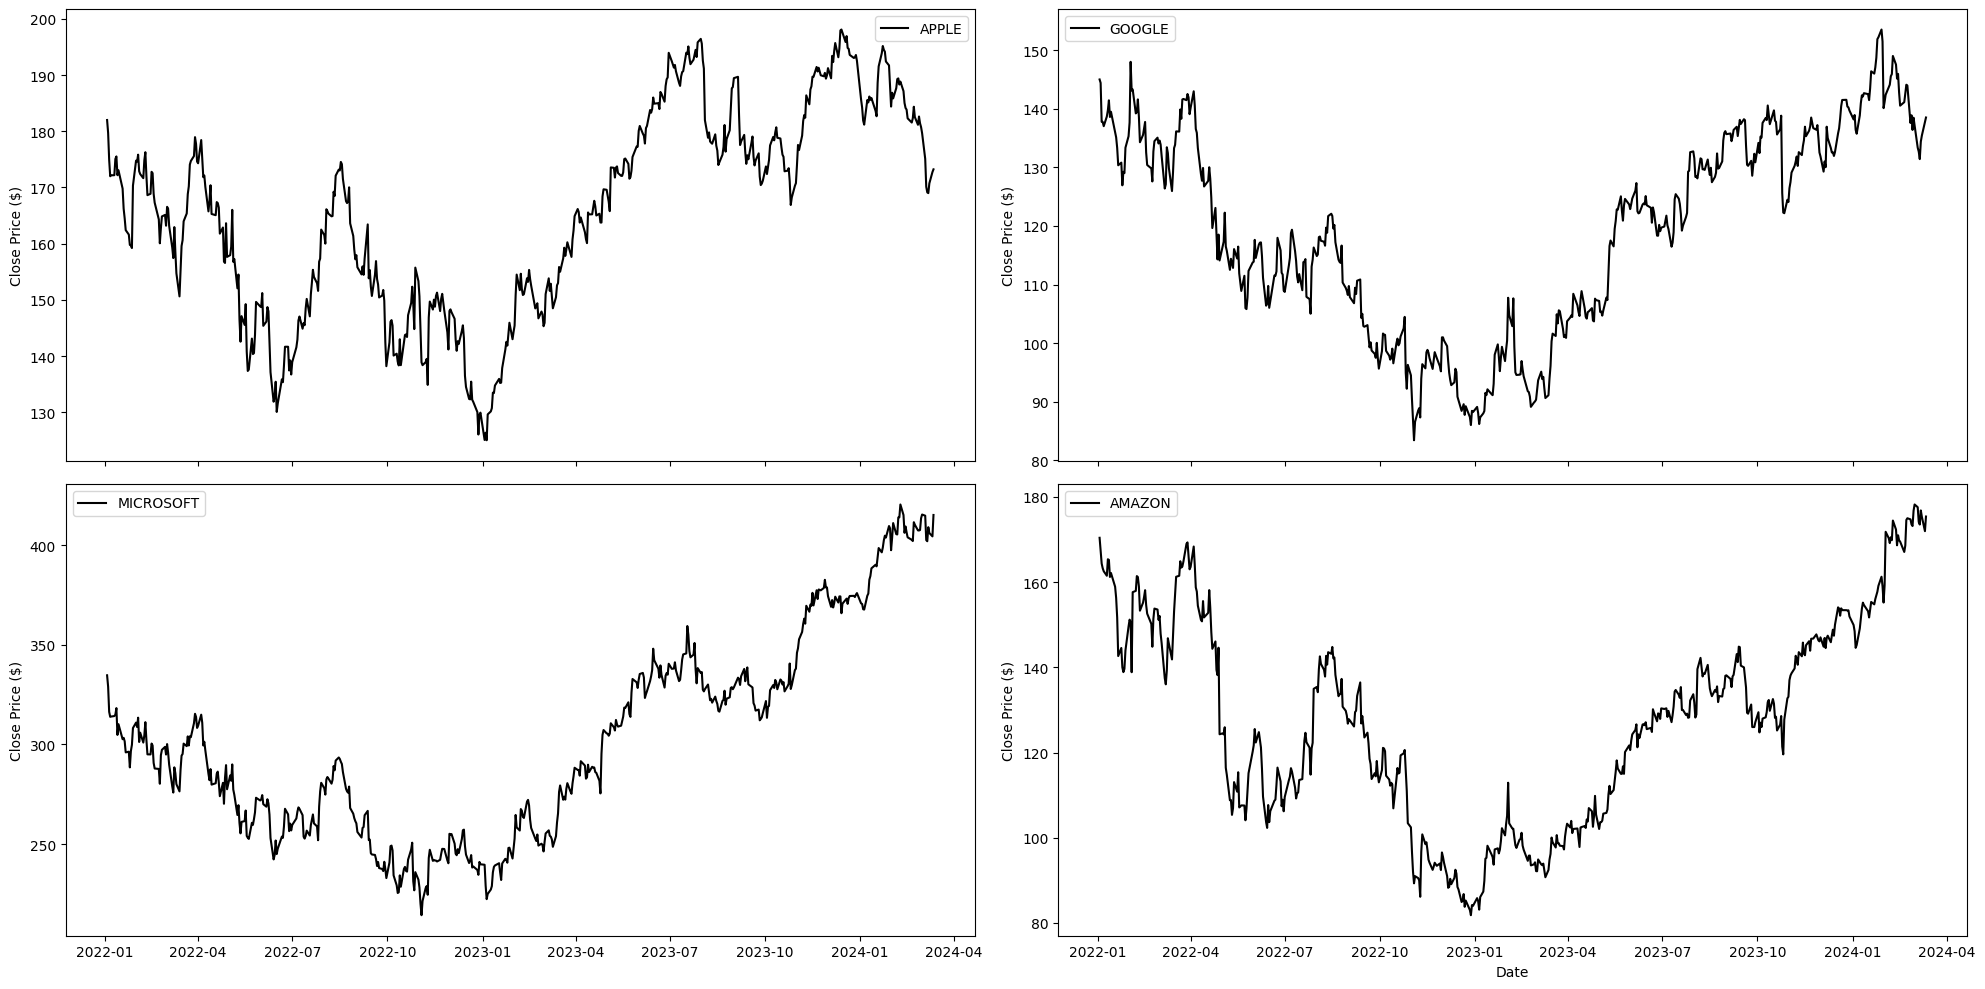

In [7]:
# filter DataFrame to include only years after 2022
close_prices_df = close_prices_df[close_prices_df.index.year > 2021]

fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color=gt_color)
    axs[row, col].set_ylabel('Close Price ($)')
    axs[row, col].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

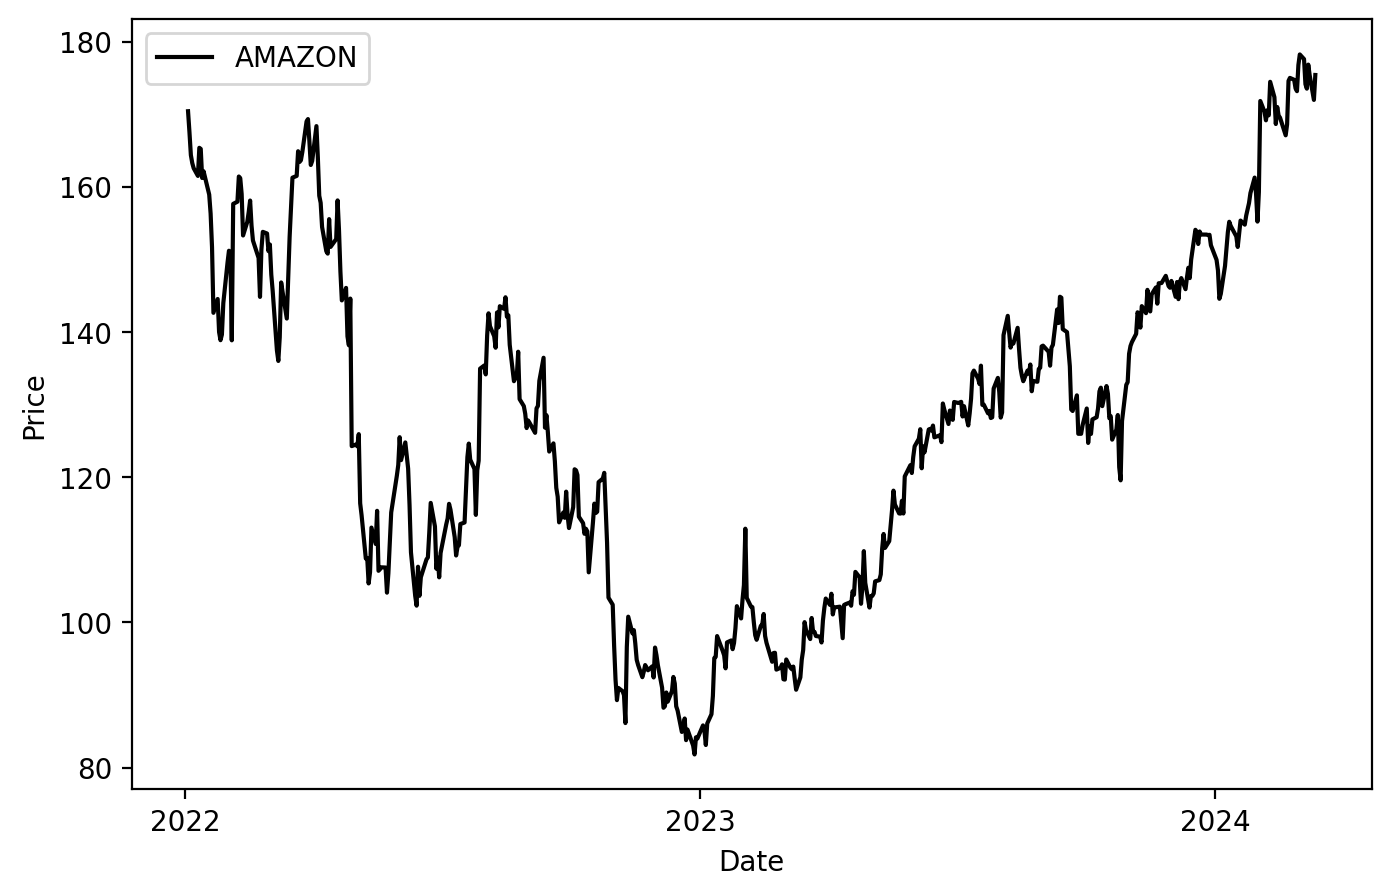

In [8]:
plot_individual_stock(df=close_prices_df, name='AMAZON', year_ticks=True)

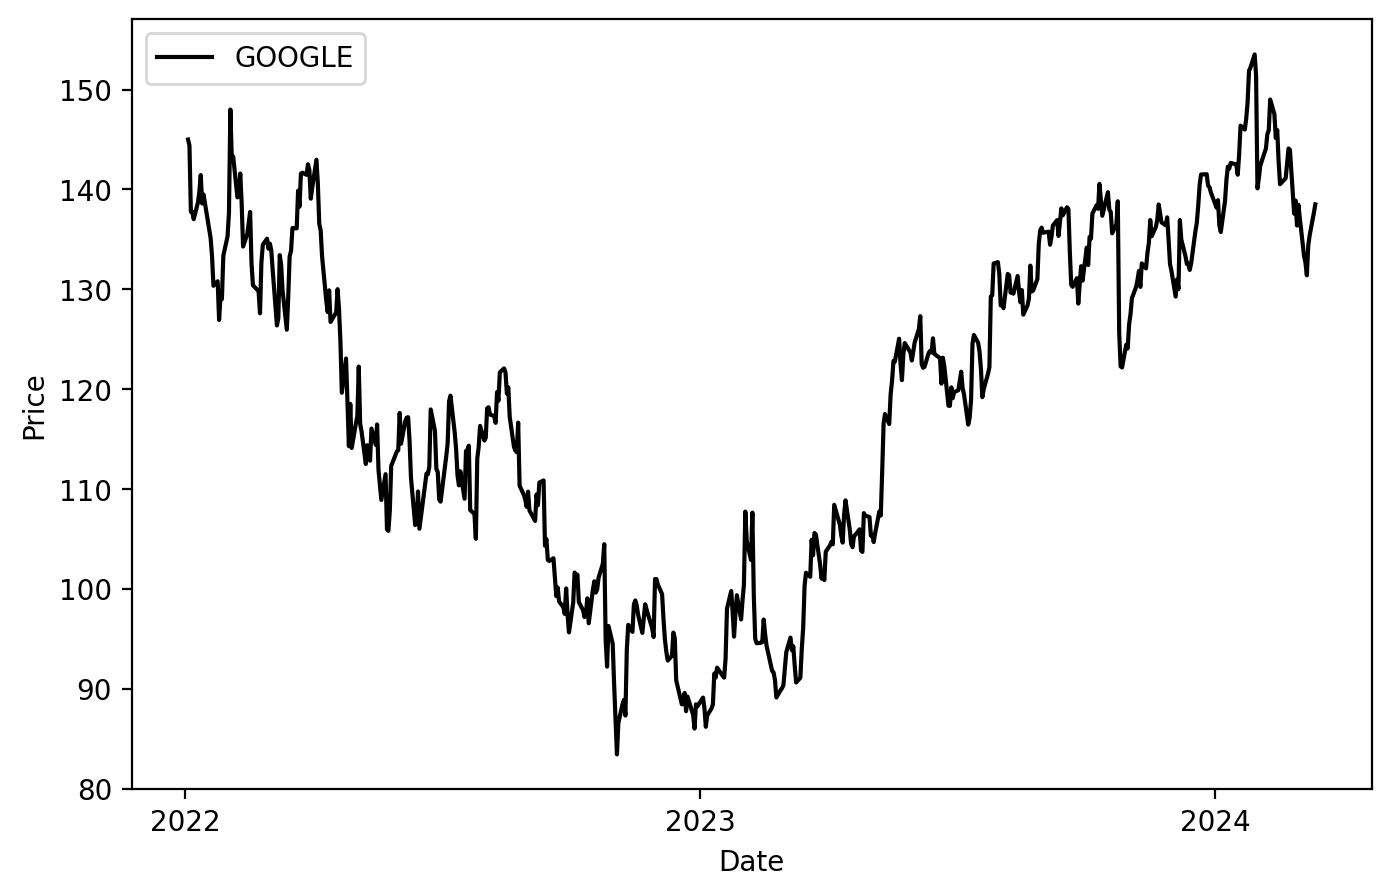

In [9]:
plot_individual_stock(df=close_prices_df, name='GOOGLE', year_ticks=True)

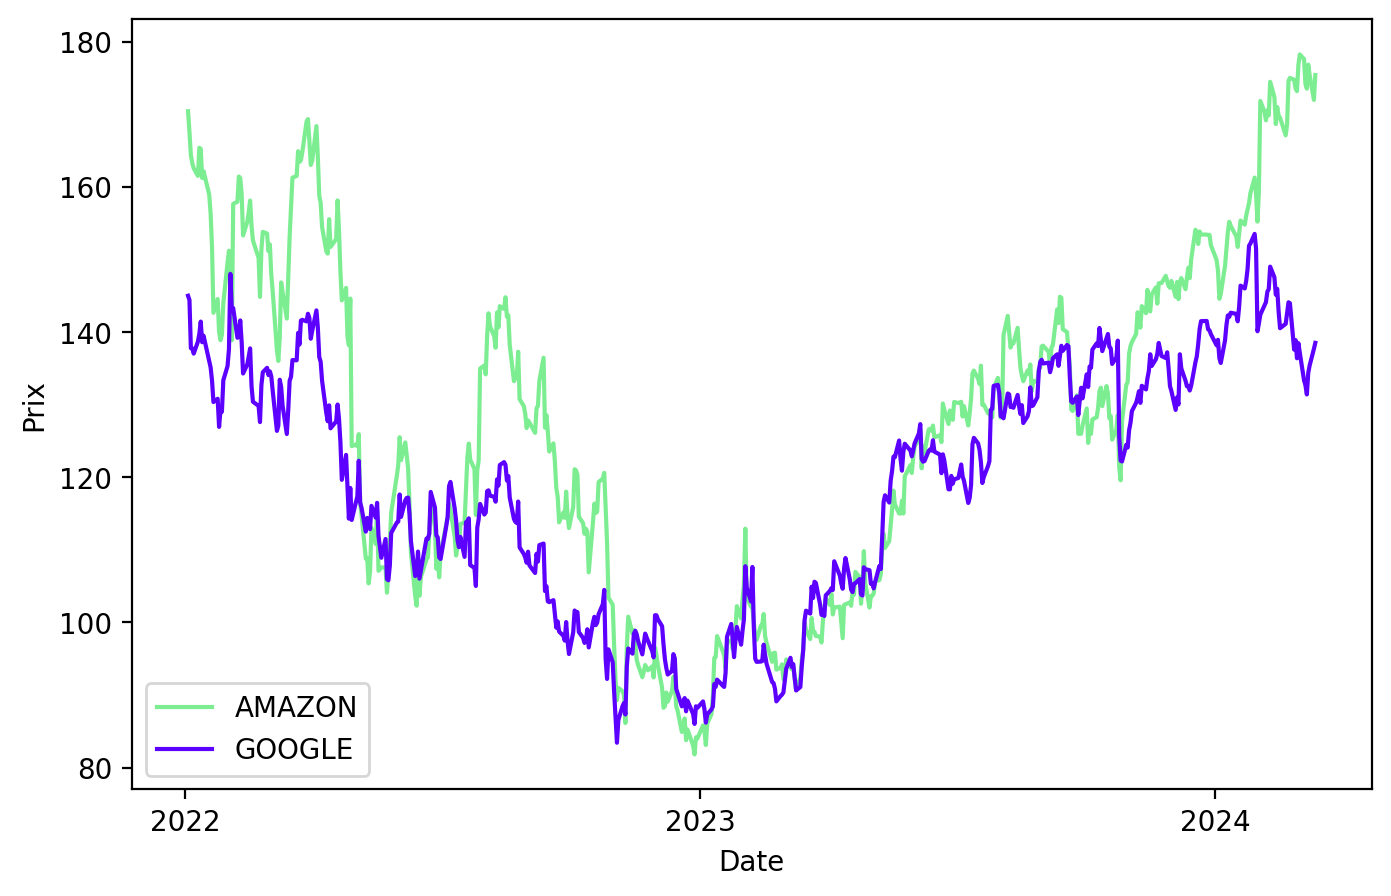

In [10]:
plt.figure(figsize=(8,5), dpi=200)
plt.plot(close_prices_df.index, close_prices_df['AMAZON'], label='AMAZON', color='#7DED92')
plt.plot(close_prices_df.index, close_prices_df['GOOGLE'], label='GOOGLE', color='#5C00FF')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.show()

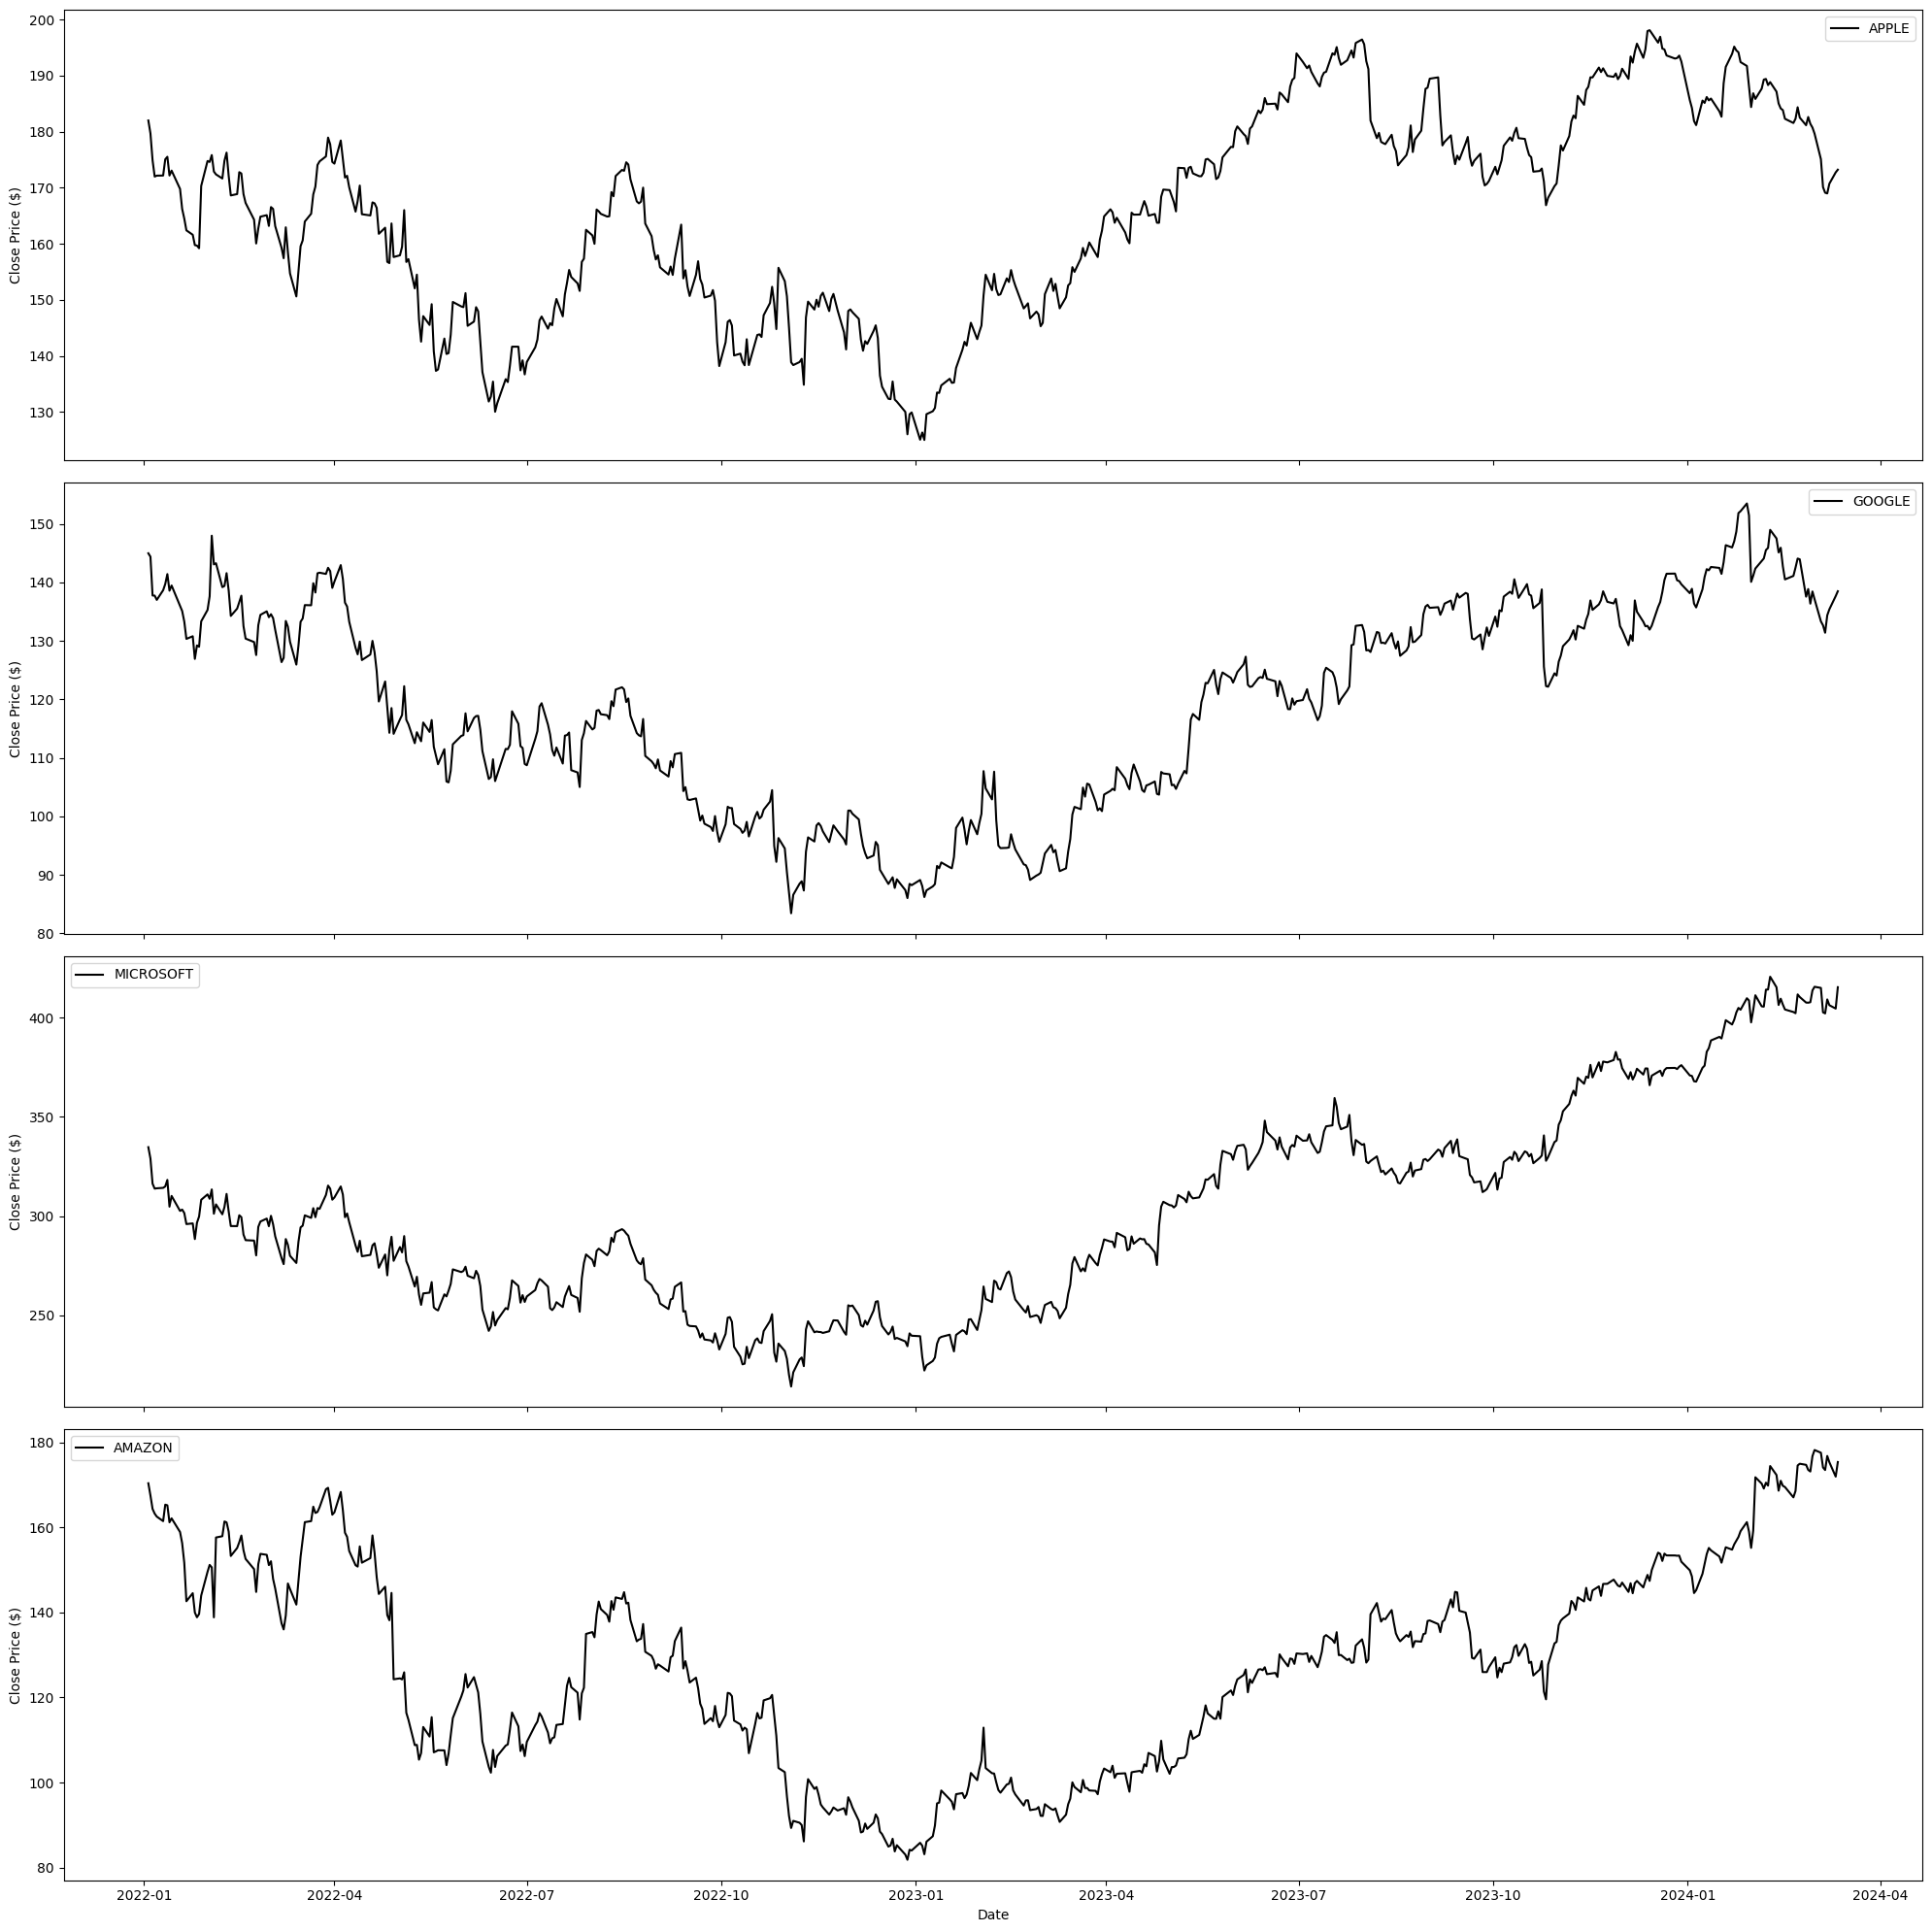

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(20, 20), sharex=True)

for i, col in enumerate(close_prices_df.columns):
    axs[i].plot(close_prices_df.index, close_prices_df[col], label=col, color=gt_color)
    axs[i].set_ylabel('Close Price ($)')
    axs[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

GARCH

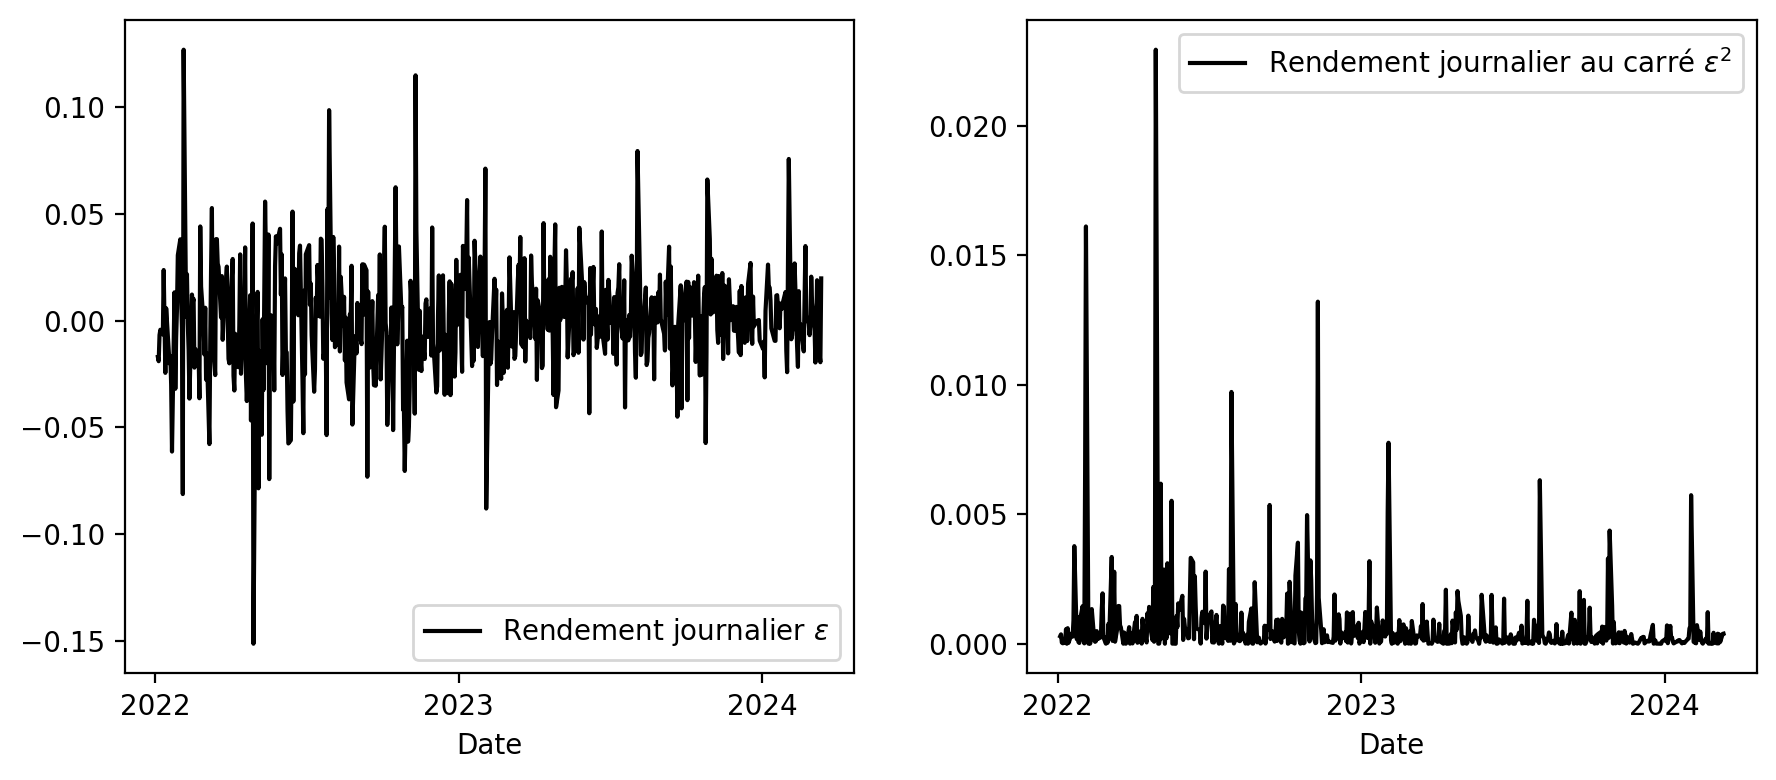

In [12]:
df_amzn = close_prices_df[['AMAZON']].copy()
df_amzn.rename(columns={'AMAZON': 'close'}, inplace=True)

# compute daily returns
df_amzn['return'] = np.log(df_amzn['close'] / df_amzn['close'].shift(1))
df_amzn['return_squared'] = df_amzn['return'] ** 2
df_amzn.dropna(inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(9.2,4),dpi=200)

axs[0].plot(df_amzn.index, df_amzn['return'], color=gt_color, label=r'Rendement journalier $\varepsilon$')
axs[0].set_xlabel('Date')
axs[0].legend()

axs[1].plot(df_amzn.index, df_amzn['return_squared'], color=gt_color, label=r'Rendement journalier au carré $\varepsilon^2$')
axs[1].set_xlabel('Date')
axs[1].legend()

plt.tight_layout()

for ax in axs:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Fitting GARCH

In [13]:
p, q = 3,3
model = arch.arch_model(df_amzn['return'], vol='Garch', p=p, q=q)

# split date
split_date = dt.datetime(2023, 6, 1)
split_index = df_amzn.index.get_loc(split_date)
x = np.arange(split_index, len(df_amzn))

# Ffit GARCH(p,q) model using data up to the split date
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 32300690.55221889
Iteration:      2,   Func. Count:     25,   Neg. LLF: 222340.7856026819
Iteration:      3,   Func. Count:     35,   Neg. LLF: 5577.996953686996
Iteration:      4,   Func. Count:     46,   Neg. LLF: -681.9224174458902
Iteration:      5,   Func. Count:     56,   Neg. LLF: -749.7667650016588
Iteration:      6,   Func. Count:     66,   Neg. LLF: -754.4149024912423
Iteration:      7,   Func. Count:     76,   Neg. LLF: -741.1124486955023
Iteration:      8,   Func. Count:     86,   Neg. LLF: -752.9821840276279
Iteration:      9,   Func. Count:     96,   Neg. LLF: -755.3869147679978
Iteration:     10,   Func. Count:    105,   Neg. LLF: -755.4345569332215
Iteration:     11,   Func. Count:    114,   Neg. LLF: -755.4382889944295
Iteration:     12,   Func. Count:    123,   Neg. LLF: 1057.0079008614773
Iteration:     13,   Func. Count:    138,   Neg. LLF: 164.40920435264223
Optimization terminated successfully    (Exit mode 0)


/Users/tessbreton/Documents/polytechnique/3A/MAP565 Modélisation aléatoire et Statistiques des processus/time-series-project/.venv/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [14]:
forecasts = res.forecast(horizon=len(df_amzn.index[x]), start=split_date, method="simulation")
sims = forecasts.simulations

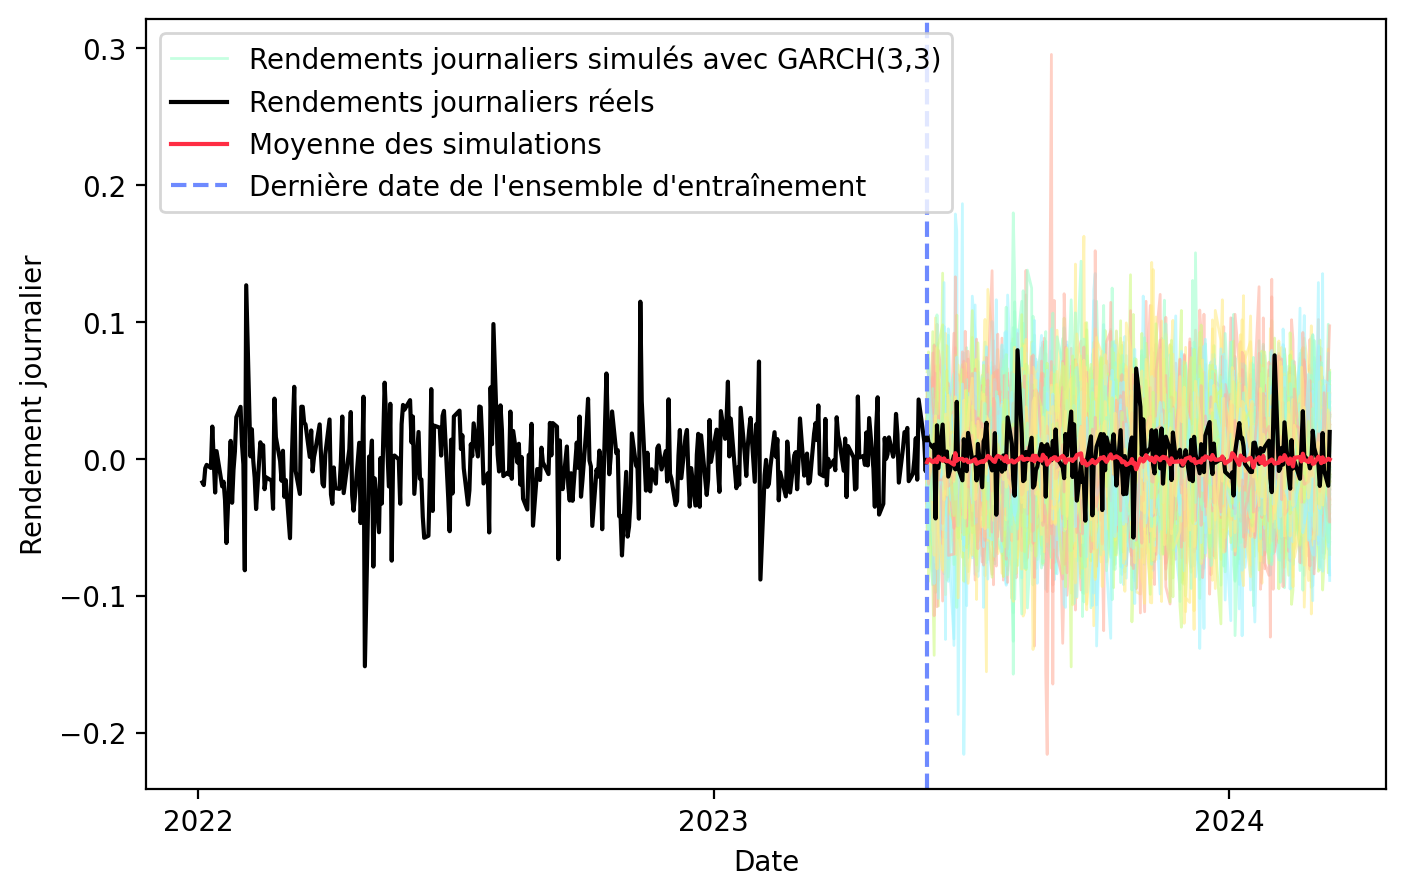

In [15]:
plt.figure(figsize=(8,5), dpi=200)

nb_sim = 200
colors = ['#A0FFCE', "#A0F4FF", "#D0FB85", "#FFB19F", "#FFEC88"]
mean_simulations = np.mean(sims.values[-1, :nb_sim], axis=0)

# plot simulations 
for i in range(nb_sim):
    plt.plot(df_amzn.index[x], sims.values[-1, i].T, color=colors[i%5], alpha=0.6, linewidth=1, label=f'Rendements journaliers simulés avec GARCH({p},{q})')

# plot ground truth data
plt.plot(df_amzn.index, df_amzn['return'], label='Rendements journaliers réels', color=gt_color)

# plot mean over all simulations for each timestamp
plt.plot(df_amzn.index[x], mean_simulations, color=mean_color, label="Moyenne des simulations")

# plot vertical line to split train/test
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")

plt.ylabel('Rendement journalier')
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()


Obtenir les prédictions du cours de l'action à partir des rendements:

In [16]:
# get the last observed closing price before the split date
prev_close = df_amzn['close'].iloc[split_index - 1]
predicted_prices = get_predicted_prices(sims, nb_sim, prev_close)
predicted_prices = predicted_prices[1:]
predicted_prices = np.array(predicted_prices)

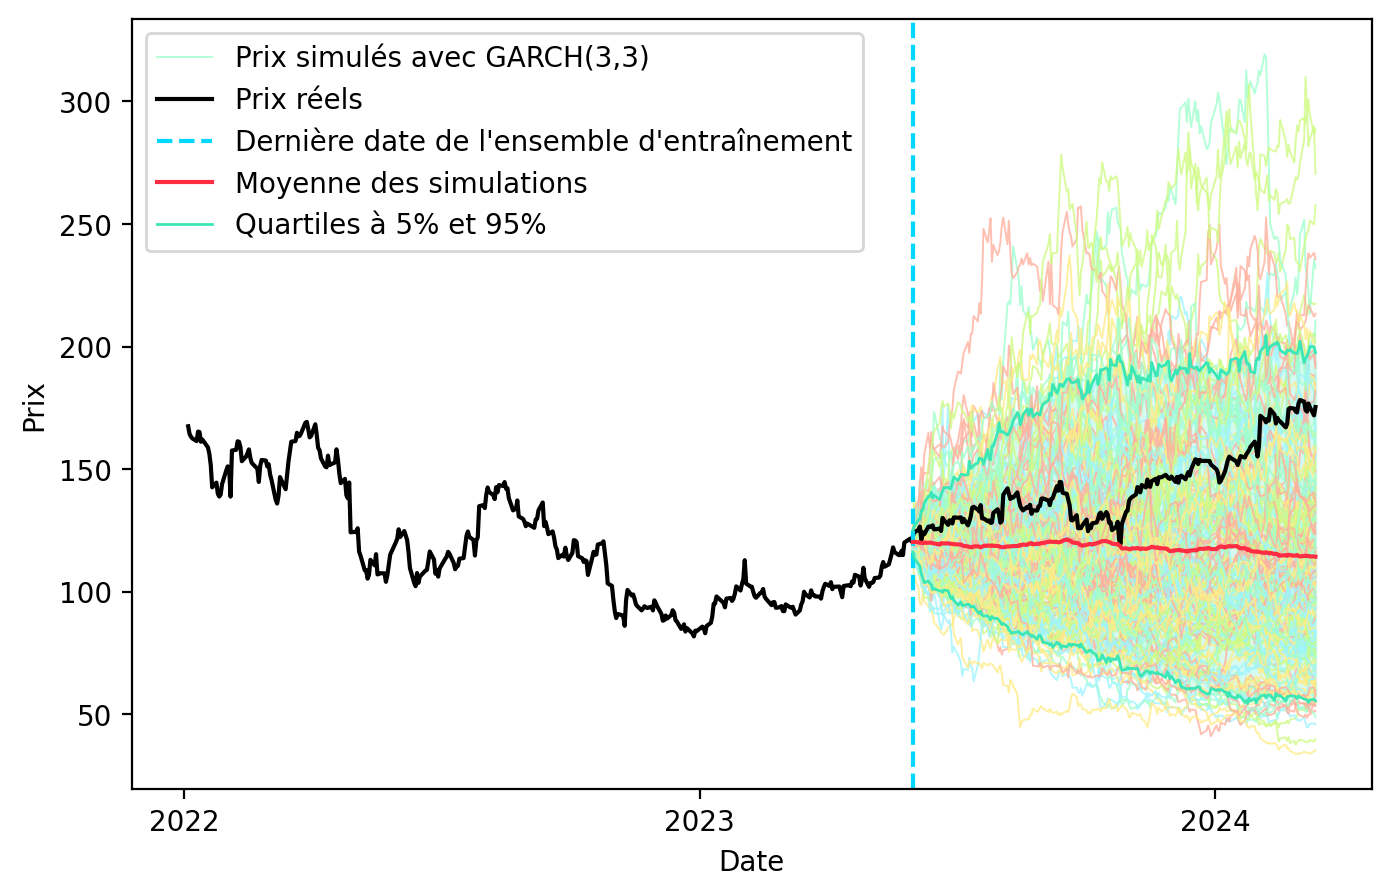

In [17]:
plt.figure(figsize=(8, 5), dpi=200)

quartile_color = '#4E62FF'
dashed_line_color = '#00D8FF'
x_pred = df_amzn.index[x]

for i in range(np.shape(predicted_prices)[1]):
    plt.plot(x_pred, predicted_prices[:,i], color=colors[i%5], alpha=0.8, linewidth=0.7, label=f"Prix simulés avec GARCH({p},{q})")

plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")
plt.plot(x_pred, np.mean(predicted_prices,axis=1), label='Moyenne des simulations', color=mean_color)

quartile_color ='#3BE7B6'
quartile_5, quartile_95 = get_quartiles(predicted_prices)
plt.plot(x_pred, quartile_5, color=quartile_color, lw=1, label='Quartiles à 5% et 95%')
plt.plot(x_pred, quartile_95, color=quartile_color, lw=1)
plt.fill_between(x_pred, quartile_5, quartile_95, color=quartile_color, alpha=0.2)

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()

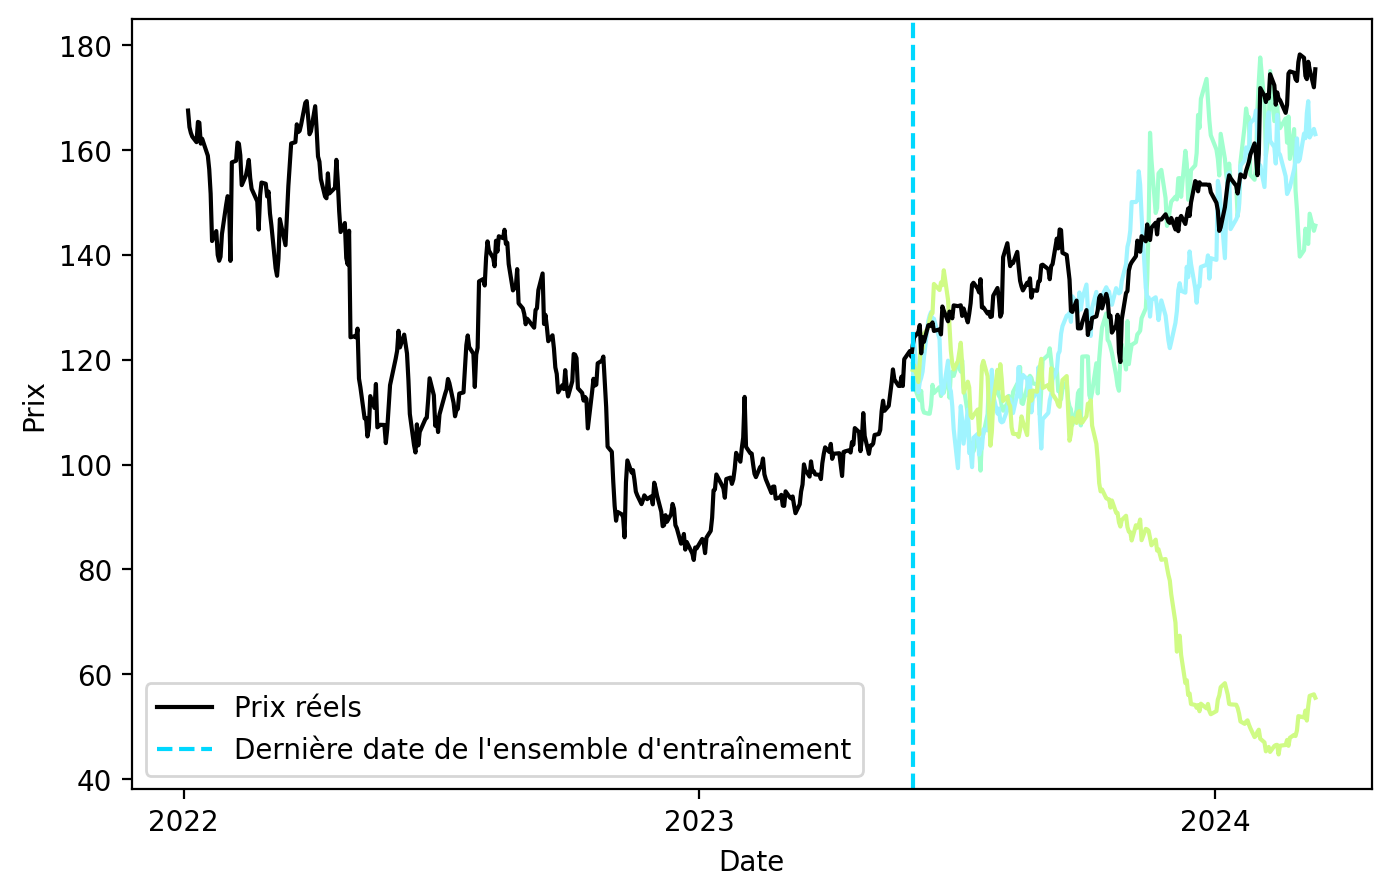

In [18]:
plt.figure(figsize=(8, 5), dpi=200)

x_pred = df_amzn.index[x]

for i in range(3):
    plt.plot(x_pred,np.array(predicted_prices)[:, i+5], color=colors[i])
plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()

Prédire le cours de l'action pour les années à venir:

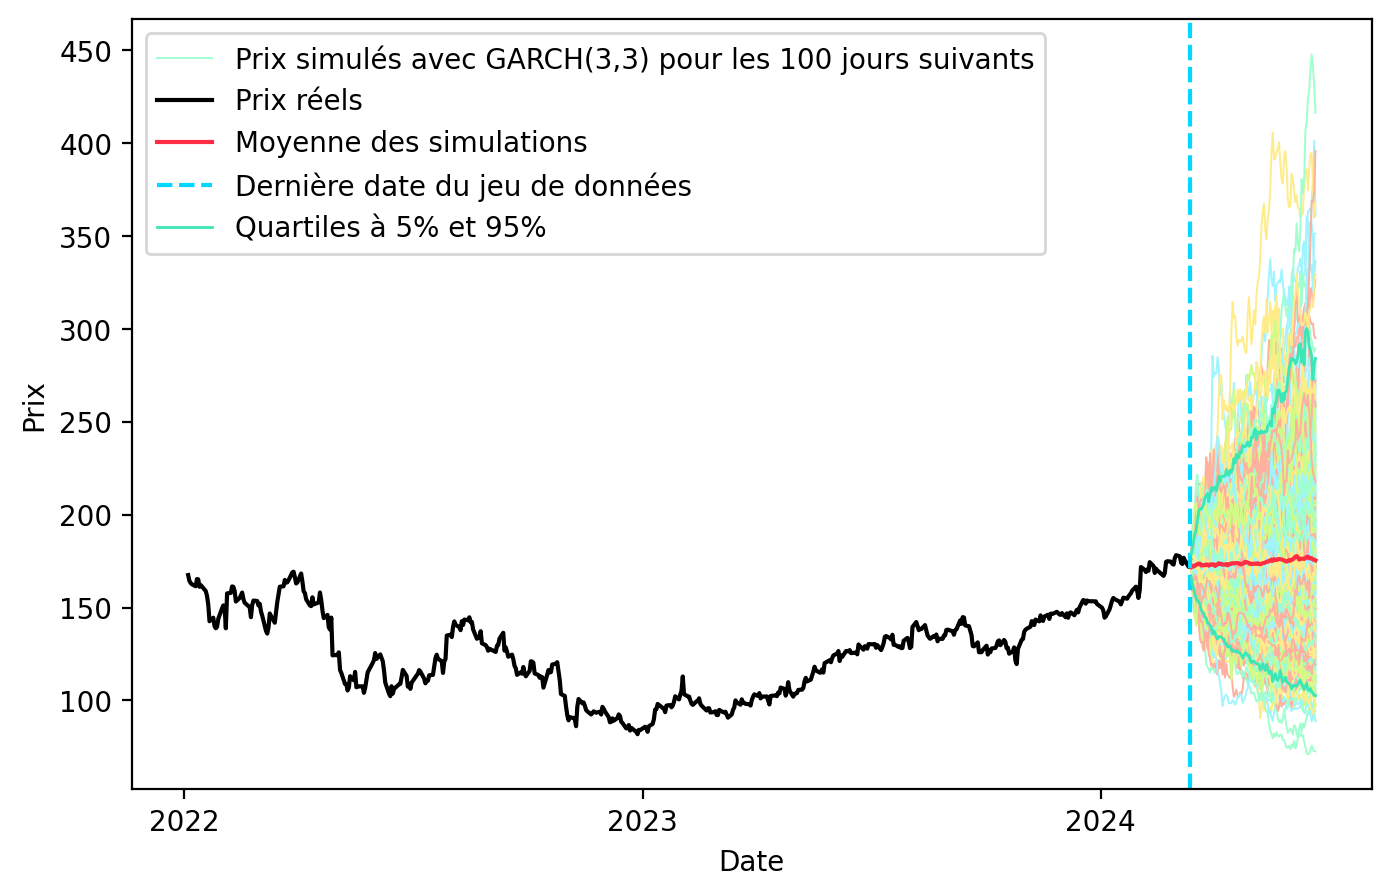

In [19]:
# find the index of the split date in df_amzn
split_index = len(df_amzn) - 1
split_date = df_amzn.index[split_index]
prev_close = df_amzn['close'].iloc[split_index - 1]

horizon = 100

# make forecasts for the next 100 days after the split date
forecasts = res.forecast(horizon=horizon, start=split_date, method='simulation')
sims = forecasts.simulations
predicted_prices = get_predicted_prices(sims, nb_sim, prev_close)
predicted_prices = predicted_prices[1:]
predicted_prices = np.array(predicted_prices)
x_pred = pd.date_range(start=df_amzn.index[split_index], periods=horizon + 1)[1:]
plt.figure(figsize=(8, 5),dpi=200)

for i in range(np.shape(predicted_prices)[1]):
    plt.plot(x_pred, predicted_prices[:,i], color=colors[i%5], linewidth=0.7, label=f"Prix simulés avec GARCH({p},{q}) pour les {horizon} jours suivants")
plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.plot(x_pred, np.mean(predicted_prices,axis=1), label='Moyenne des simulations', color=mean_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label='Dernière date du jeu de données')

# plot quartile lines
quartile_5, quartile_95 = get_quartiles(predicted_prices)
plt.plot(x_pred, quartile_5, color=quartile_color, lw=1, label='Quartiles à 5% et 95%')
plt.plot(x_pred, quartile_95, color=quartile_color, lw=1)
plt.fill_between(x_pred, quartile_5, quartile_95, color=quartile_color, alpha=0.2)

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()
plt.show()

# Copules

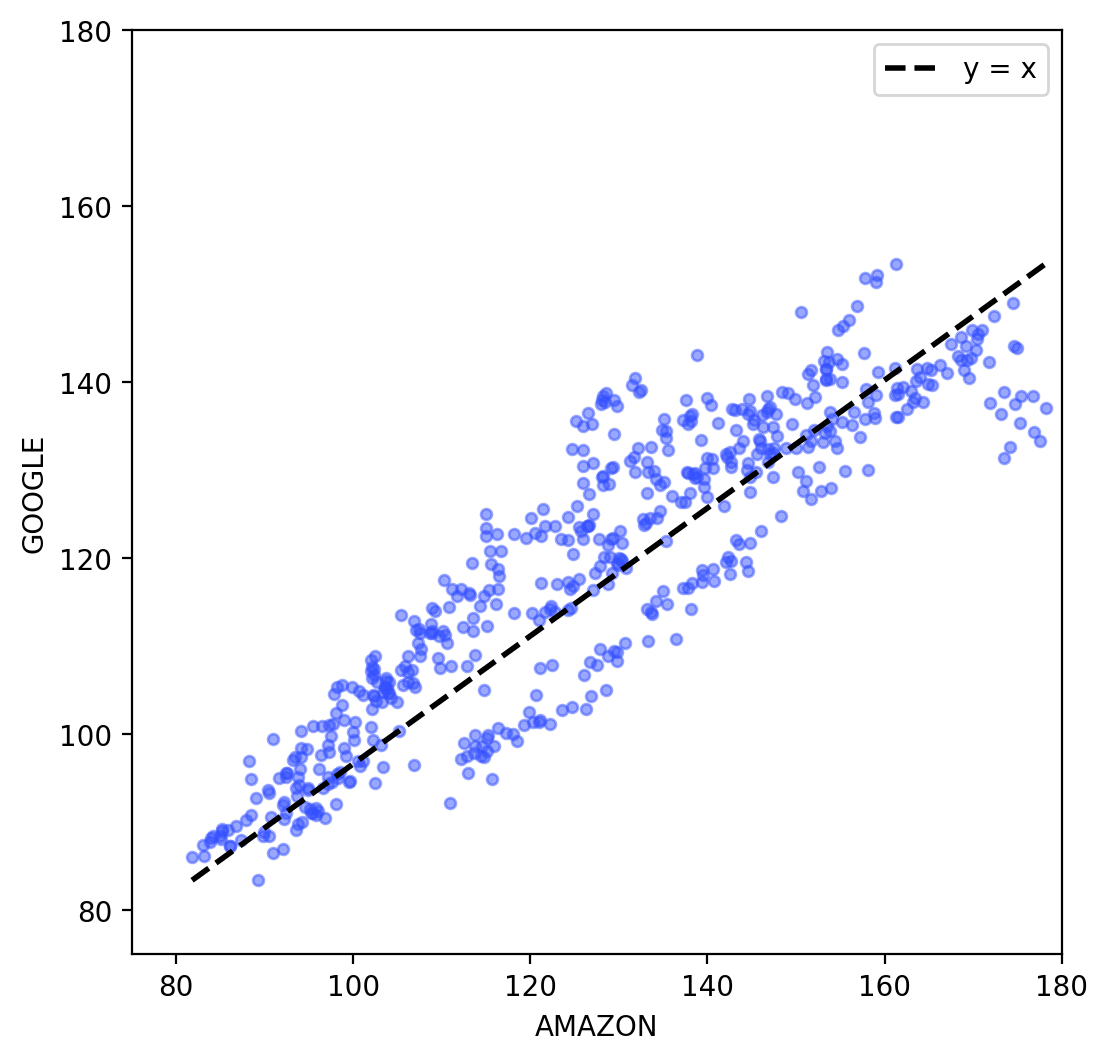

In [20]:
import numpy as np
import pandas as pd
import copulalib as cl
import matplotlib.pyplot as plt

amazon = close_prices_df['AMAZON'].values.reshape(-1, 1)
google = close_prices_df['GOOGLE'].values.reshape(-1, 1)

# calcul du coefficient de corrélation linéaire
correlation = np.corrcoef(amazon.flatten(), google.flatten())[0, 1]

plt.figure(figsize=(6,6),dpi=200)

plt.scatter(amazon, google, alpha=0.5, color='#3551FF',s=15)
plt.plot([min(amazon), max(amazon)], [min(google), max(google)], linestyle='--', color='black', lw=2, label='y = x')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.xlim(75,180)
plt.ylim(75,180)

plt.legend()
plt.show()

In [21]:
amazon = amazon[:,0]
google = google[:,0]

Gumbel
Kendall's rank correlation :  0.7397308371383315
Spearmen's correlation :  0.9086787797402931
Pearson's correlation :  0.9033571672502044
thetas
5.684352529550297
13.4954833984375
3.8421762647751483


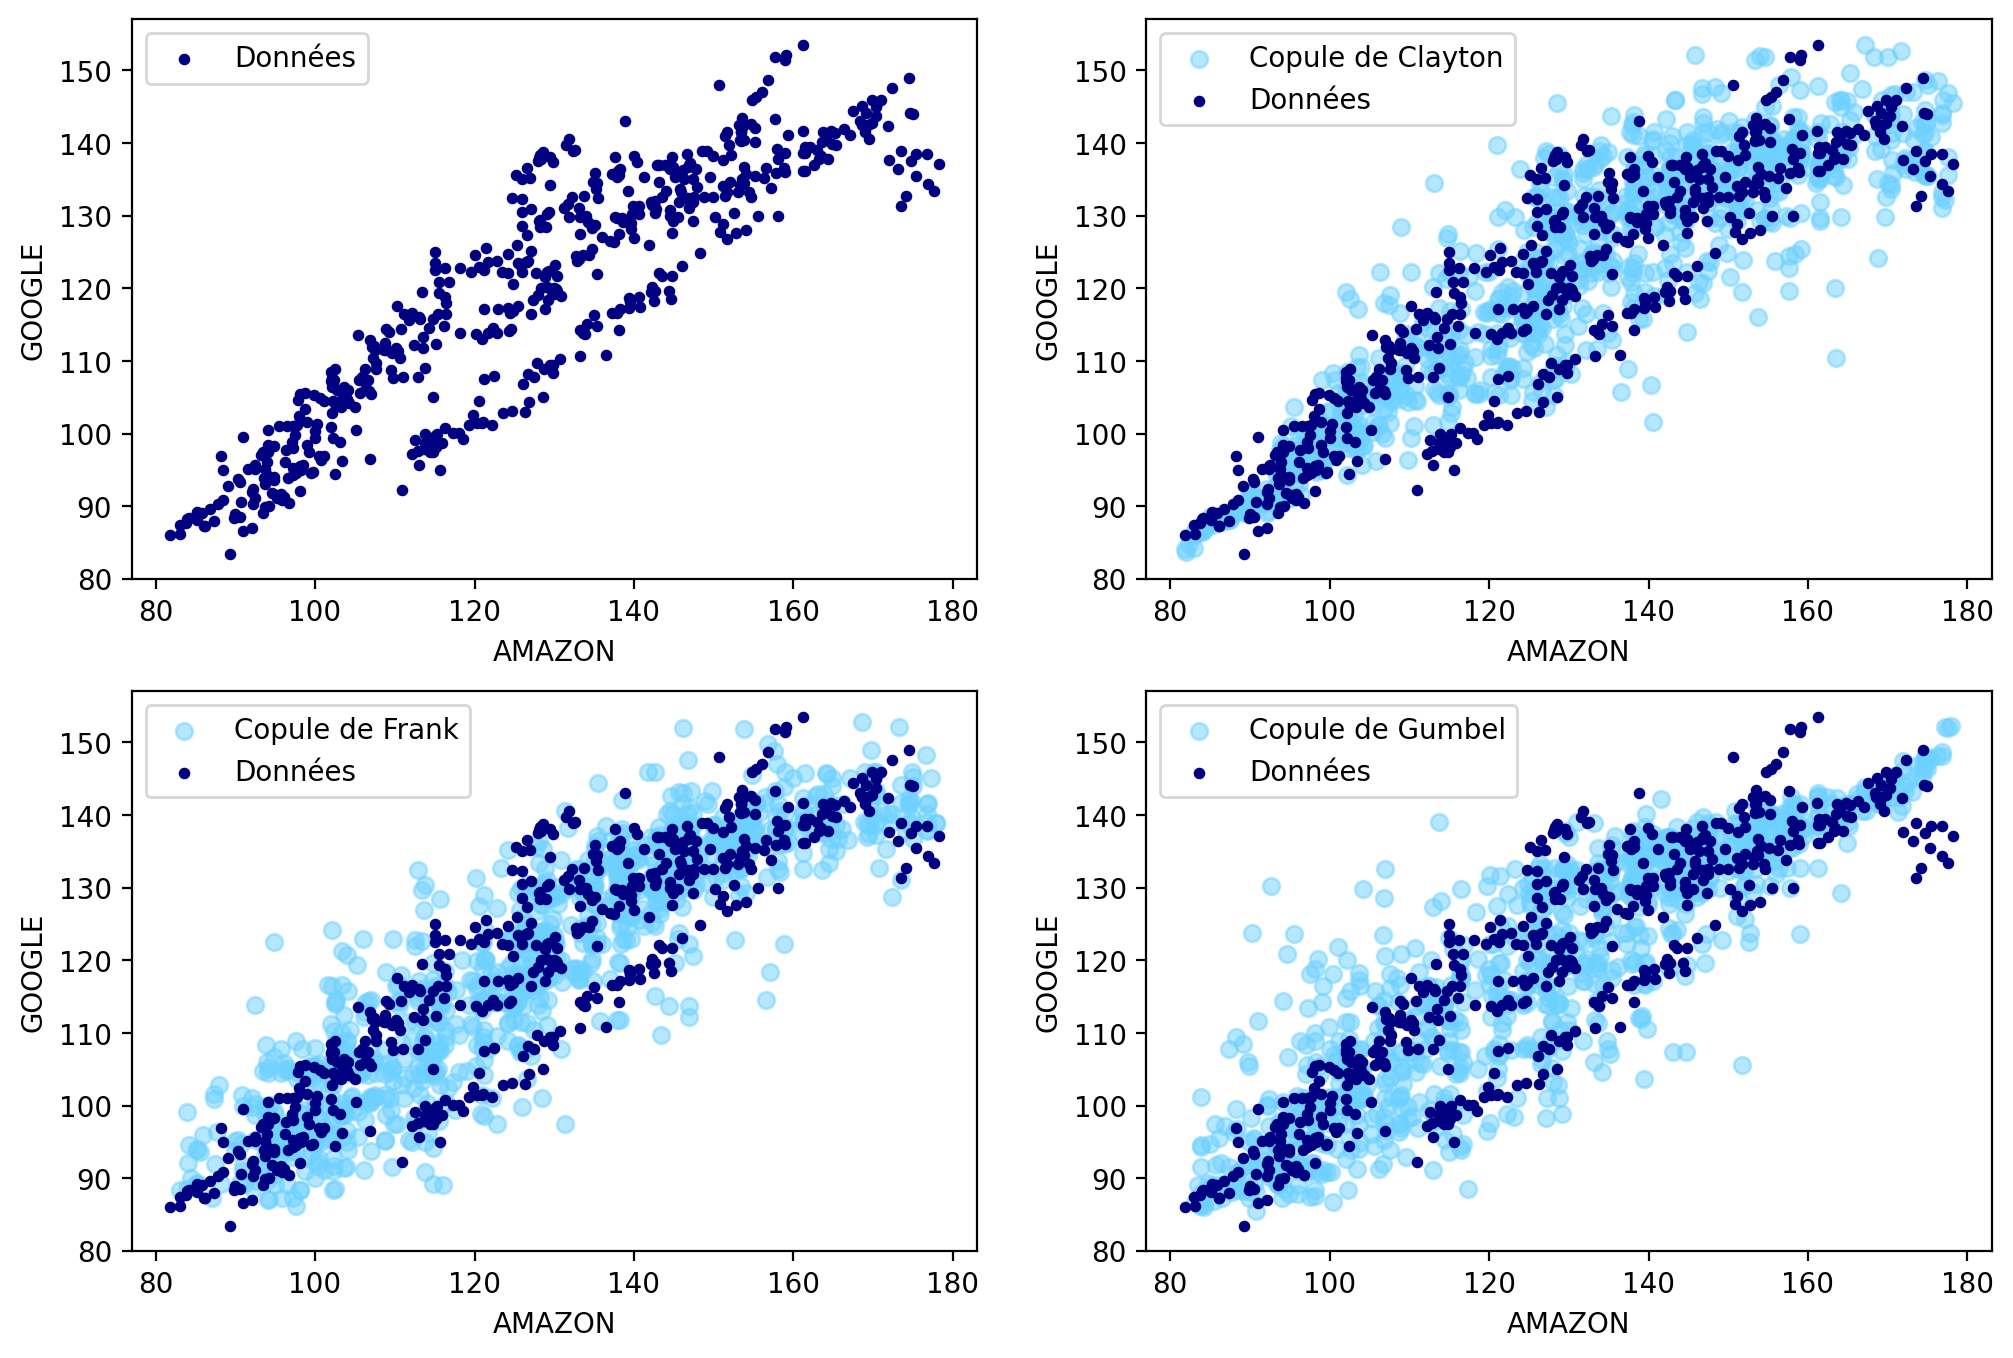

In [22]:
from copulalib.copulalib import Copula

true_color = 'navy'
copula_color = '#6DD1FF'
alpha = 0.5

x,y = amazon, google

plt.figure(figsize=(12,8),dpi=200)
plt.subplot(221)
plt.scatter(x, y, color=true_color,s=10, label='Données')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.legend()

# make the instance of Copula class with x, y and clayton family
foo_clayton = Copula(x, y, family='clayton')
foo_frank = Copula(x, y, family='frank')
foo_gumbel = Copula(x, y, family='gumbel')

print('Gumbel')
print("Kendall's rank correlation : ", foo_gumbel.tau) 
print("Spearmen's correlation : ", foo_gumbel.sr)
print("Pearson's correlation : ", foo_gumbel.pr)

print('thetas')
print(foo_clayton.theta)
print(foo_frank.theta)
print(foo_gumbel.theta)

# generate the 1000 samples (U,V) of copula
X1, Y1 = foo_clayton.generate_xy(1000)
X2, Y2 = foo_frank.generate_xy(1000)
X3, Y3 = foo_gumbel.generate_xy(1000)

plt.subplot(222)
plt.scatter(X1, Y1, color=copula_color, alpha=alpha, label='Copule de Clayton')
plt.scatter(x,y, color=true_color,s=10, label='Données')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.legend()

plt.subplot(223)
plt.scatter(X2, Y2, color=copula_color, alpha=alpha, label='Copule de Frank')
plt.scatter(x,y, color=true_color,s=10, label='Données')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.legend()

plt.subplot(224)
plt.scatter(X3, Y3, color=copula_color, alpha=alpha, label='Copule de Gumbel')
plt.scatter(x,y, color=true_color,s=10, label='Données')
plt.xlabel('AMAZON')
plt.ylabel('GOOGLE')
plt.legend()

plt.show()

In [23]:
print('True Data :')
pearson, spearman, kendall = pearsonr(amazon, google)[0], spearmanr(amazon, google)[0], kendalltau(amazon, google)[0]
print('pearson : {:.3f}, spearman : {:.3f}, kendall : {:.3f}\n'.format(pearson, spearman, kendall))

# Clayton
valid_indices = ~np.isnan(X1) & ~np.isnan(Y1) & ~np.isinf(X1) & ~np.isinf(Y1)
X1_filtered = X1[valid_indices]
Y1_filtered = Y1[valid_indices]

pearson1 = pearsonr(X1_filtered, Y1_filtered)[0]
spearman1 = spearmanr(X1_filtered, Y1_filtered)[0]
kendall1 = kendalltau(X1_filtered, Y1_filtered)[0]
print('Clayton :')
print('pearson : {:.3f}, spearman : {:.3f}, kendall : {:.3f}\n'.format(pearson1, spearman1, kendall1))

# Frank
valid_indices = ~np.isnan(X2) & ~np.isnan(Y2) & ~np.isinf(X2) & ~np.isinf(Y2)
X2_filtered = X2[valid_indices]
Y2_filtered = Y2[valid_indices]

pearson2 = pearsonr(X2_filtered, Y2_filtered)[0]
spearman2 = spearmanr(X2_filtered, Y2_filtered)[0]
kendall2 = kendalltau(X2_filtered, Y2_filtered)[0]
print('Frank :')
print('pearson : {:.3f}, spearman : {:.3f}, kendall : {:.3f}\n'.format(pearson2, spearman2, kendall2))

# Gumbel
valid_indices = ~np.isnan(X3) & ~np.isnan(Y3) & ~np.isinf(X3) & ~np.isinf(Y3)
X3_filtered = X3[valid_indices]
Y3_filtered = Y3[valid_indices]

pearson3 = pearsonr(X3_filtered, Y3_filtered)[0]
spearman3 = spearmanr(X3_filtered, Y3_filtered)[0]
kendall3 = kendalltau(X3_filtered, Y3_filtered)[0]
print('Gumbel :')
print('pearson : {:.3f}, spearman : {:.3f}, kendall : {:.3f}\n'.format(pearson3, spearman3, kendall3))

True Data :
pearson : 0.903, spearman : 0.909, kendall : 0.740

Clayton :
pearson : 0.901, spearman : 0.897, kendall : 0.732

Frank :
pearson : 0.893, spearman : 0.908, kendall : 0.730

Gumbel :
pearson : 0.889, spearman : 0.896, kendall : 0.724

